# Getting preprocessed data from Drive
You can use the following code and jump directly to the section called "Splitting Data"

In [17]:
import numpy as np
import pandas as pd

# Loading train data
print("Loading train data")
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1npO_wryJ--RXGHOPxgYIoyQEkzFI28_M',
                                    dest_path='./train_set.npy')
input_data = np.load("/content/train_set.npy")

# Load test data
print("Loading test data")
gdd.download_file_from_google_drive(file_id='1oCzoiUXULYHxlgMEyT9Acl27vv5IEne2',
                                    dest_path='/content/test_set.npy')

# Loading train meteadata
print("Loading train metadata")
gdd.download_file_from_google_drive(file_id='1EHCPitrGOq5kcu3sgJJ85Dog796WPc8-',
                                    dest_path='/content/metadata_train.csv')

# Loading test metadata
print("Loading test metadata")
gdd.download_file_from_google_drive(file_id='1MUWqvAwDrQfryRILNQ2J0MUabxWQUTRZ',
                                    dest_path='/content/metadata_test.csv')
  
# Allocating data
print("Allocating data")
input_dataset = np.load("/content/train_set.npy")
test_data = np.load("/content/test_set.npy")
metadata = pd.read_csv("/content/metadata_train.csv")
metadata_test = pd.read_csv("/content/metadata_test.csv")

Loading train data
Loading test data
Loading train metadata
Loading test metadata
Allocating data


# Getting Data From Kaggle

In [11]:
# Get data from Kaggle
!pip install kaggle
!mkdir ~/.kaggle
!mkdir /content/.kaggle
!ls ~/.kaggle

import json
token = {"username":"mielgosez", "key":"46ef90eb86d527d54aca090759ccbef9"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

print("1. Downloading datasets")
!kaggle competitions download -c vsb-power-line-fault-detection -p /content/
print("2.  Moving train set to train folder")
!mkdir /content/train
!unzip -qq /content/train.parquet.zip -d /content/train
print("3. Moving test set to test folder")
!mkdir /content/test
!unzip -qq /content/test.parquet.zip -d /content/test


- path is now set to: {/content}
1. Downloading datasets
  0% 0.00/257k [00:00<?, ?B/s]
100% 257k/257k [00:00<00:00, 82.7MB/s]
  0% 0.00/115k [00:00<?, ?B/s]
100% 115k/115k [00:00<00:00, 37.4MB/s]
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 47.6MB/s]
100% 6.97G/6.97G [01:35<00:00, 26.3MB/s]
100% 6.97G/6.97G [01:35<00:00, 78.7MB/s]
100% 3.01G/3.02G [00:39<00:00, 66.5MB/s]
100% 3.02G/3.02G [00:39<00:00, 81.6MB/s]
2.  Moving train set to train folder
3. Moving test set to test folder


This is what metadata looks like

In [0]:
import pandas as pd
import numpy as np

path_data = '/content/'
metadata = pd.read_csv(path_data + 'metadata_train.csv')
metadata.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


And this is what signals look like

Index(['0', '1', '2'], dtype='object')


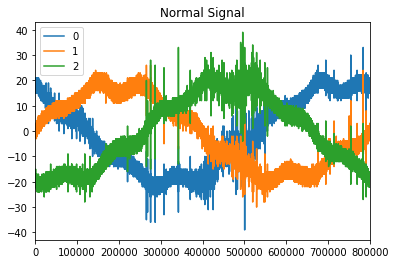

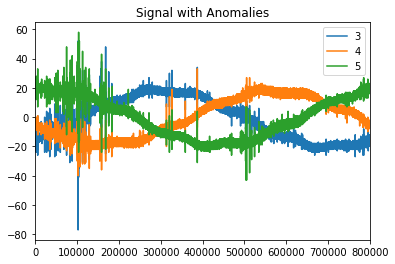

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
# Load Normal data
metadata = pd.read_csv('/content/metadata_train.csv')
signal_ids = list(metadata[metadata["id_measurement"] == 0]["signal_id"].values)
signal_ids = [str(item) for item in signal_ids]
train_0 = pd.read_parquet('/content/train/train.parquet', 
                        engine='pyarrow', 
                        columns=signal_ids)
# Load Anomalous data
signal_ids = list(metadata[metadata["id_measurement"] == 1]["signal_id"].values)
signal_ids = [str(item) for item in signal_ids]
train_1 = pd.read_parquet('/content/train/train.parquet',
                        engine='pyarrow', 
                        columns=signal_ids)
# Plot Normal signal
train_0.plot()
plt.title("Normal Signal")
plt.show()
# Plot Abnormal signal
train_1.plot()
plt.title("Signal with Anomalies")
plt.show()

# Extracting some features from Timeseries
As the signals are too large to be fed into a LSTM, let us shrink it a bit through aggregation via the following features:

* maximum
* minimum
* mean
* median
* variance
* standard deviation
* difference between maximum and minimum

Below can be found the function definition.

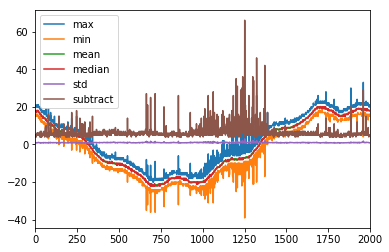

In [0]:
import pandas as pd
import numpy as np

def agg_timeseries(input_df: pd.DataFrame, 
                   agg_size: int = 800):
  """
  This functions will reduce the size of the initial timeseries aiming to ease 
  the performance for the Long Short Term Memory in Keras.
  input_df: Initial time series 
  agg_size: It represents the window size. default value is 800. That means if 
            original ts length is 800k, then it will be reduced to 1k.
  returns: A timeseries of input_df.shape[0]/agg_size length
  """
  df = input_df.copy()
  # Creating the dummy aggregator index.
  dummy_aggregator = []
  number_obs = int(df.shape[0]/agg_size)
  for obs in range(number_obs):
    dummy_aggregator.extend([obs]*agg_size)
  df['dummy_index'] = dummy_aggregator
  # Collapsing the timeseries.
  df_max = df.groupby('dummy_index').max()
  df_min = df.groupby('dummy_index').min()
  df_mean = df.groupby('dummy_index').mean()
  df_median = df.groupby('dummy_index').median()
  df_std = df.groupby('dummy_index').std()
  df_max.reset_index(inplace=True)
  df_min.reset_index(inplace=True)
  df_mean.reset_index(inplace=True)
  df_median.reset_index(inplace=True)
  df_std.reset_index(inplace=True)
  df_max.drop('dummy_index', axis=1, inplace=True)
  df_min.drop('dummy_index', axis=1, inplace=True)
  df_mean.drop('dummy_index', axis=1, inplace=True)
  df_median.drop('dummy_index', axis=1, inplace=True)
  df_std.drop('dummy_index', axis=1, inplace=True)
  df_subtract = df_max.subtract(df_min)
  df_max.columns = ['max']
  df_min.columns = ['min']
  df_mean.columns = ['mean']
  df_median.columns = ['median']
  df_std.columns = ['std']
  df_subtract.columns = ['subtract']
  return pd.concat([df_max, df_min, df_mean, df_median, df_std, df_subtract], axis = 1)
  
test_df = pd.read_parquet('/content/train/train.parquet', 
                        engine='pyarrow', 
                        columns=["0"])
test_df = agg_timeseries(test_df, agg_size=400)
test_df.plot()

Generating our input

In [0]:
import time
input_dataset = list()
signal_ids = list(metadata['signal_id'])
initial_time = time.time()
for items in signal_ids:
  train_df = pd.read_parquet('/content/train/train.parquet', 
                        engine='pyarrow', 
                        columns=[str(items)])
  input_dataset.append(agg_timeseries(train_df).values)
  if items % 100 == 0:
    print('Adding '+str(items)+' dataset. Time: '+str(time.time()-initial_time))


Adding 0 dataset. Time: 0.5482127666473389
Adding 100 dataset. Time: 64.38337683677673
Adding 200 dataset. Time: 128.03911781311035
Adding 300 dataset. Time: 190.47537684440613
Adding 400 dataset. Time: 253.65897512435913
Adding 500 dataset. Time: 317.03026509284973
Adding 600 dataset. Time: 381.5121970176697
Adding 700 dataset. Time: 445.90269017219543
Adding 800 dataset. Time: 510.113578081131
Adding 900 dataset. Time: 574.7414741516113
Adding 1000 dataset. Time: 639.5093193054199
Adding 1100 dataset. Time: 703.4829483032227
Adding 1200 dataset. Time: 767.8253872394562
Adding 1300 dataset. Time: 832.0309042930603
Adding 1400 dataset. Time: 896.8110542297363
Adding 1500 dataset. Time: 960.3641636371613
Adding 1600 dataset. Time: 1023.872385263443
Adding 1700 dataset. Time: 1086.9148259162903
Adding 1800 dataset. Time: 1150.523140668869
Adding 1900 dataset. Time: 1214.7878935337067
Adding 2000 dataset. Time: 1278.4561684131622
Adding 2100 dataset. Time: 1341.957885503769
Adding 2200 da

In [0]:
# Converting this list into numpy array
input_dataset = np.array(input_dataset)
np.save("train_set.npy", input_dataset)

# Splitting Data
Let's split data by defining a train and validation sets

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(input_dataset, 
                                                  np.array(metadata["target"]), 
                                                  test_size=0.20, 
                                                  random_state=42)


In [0]:
# Scale data
X_train_scaled = np.divide(X_train, 20)
X_val_scaled = np.divide(X_val, 20)

# Defining the Architecture 1: LSTM + Dense
Let's get started with a simple architecture consiting of a LSTM and a dense layer.

Matthews Correlation Achieved on Kaggle: 0.42

In [0]:
from sklearn.metrics import matthews_corrcoef
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dense, Dropout
from keras.layers import LSTM


model = Sequential()
model.add(LSTM(100, input_shape=(1000,6)))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               42800     
_________________________________________________________________
dense_37 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 202       
Total params: 53,102
Trainable params: 53,102
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

y_binary = np.array(y_train).reshape(-1, 1)
y_binary = to_categorical(y_binary)
verbose, epochs, batch_size = 0, 35, 64

model.fit(X_train, y_binary, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1)

W0624 19:38:11.703692 140563064059776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0624 19:38:12.286176 140563064059776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 6272 samples, validate on 697 samples
Epoch 1/35
6272/6272 [==============================] - 142s 23ms/step - loss: 0.2608 - acc: 0.9157 - val_loss: 0.1804 - val_acc: 0.9527
Epoch 2/35
6272/6272 [==============================] - 136s 22ms/step - loss: 0.2168 - acc: 0.9388 - val_loss: 0.1707 - val_acc: 0.9541
Epoch 3/35
6272/6272 [==============================] - 135s 22ms/step - loss: 0.2028 - acc: 0.9388 - val_loss: 0.1620 - val_acc: 0.9527
Epoch 4/35
6272/6272 [==============================] - 135s 21ms/step - loss: 0.1985 - acc: 0.9362 - val_loss: 0.1658 - val_acc: 0.9527
Epoch 5/35
6272/6272 [==============================] - 135s 21ms/step - loss: 0.1841 - acc: 0.9431 - val_loss: 0.1527 - val_acc: 0.9541
Epoch 6/35
6272/6272 [==============================] - 134s 21ms/step - loss: 0.1866 - acc: 0.9424 - val_loss: 0.1668 - val_acc: 0.9527
Epoch 7/35
6272/6272 [==============================] - 135s 21ms/step - loss: 0.1852 - acc: 0.9432 - val_loss: 0.1597 - val_acc: 0

KeyboardInterrupt: ignored

In [0]:
results_train = model.predict(X_val)
converted_result_train = []
for item in results_train:
  if item[0] > item[1]:
    converted_result_train.append(0)
  else:
    converted_result_train.append(1)
converted_result_train = np.array(converted_result_train)
matthews_corrcoef(y_val, converted_result_train)

0.48430213896071644

In [0]:
model.save("model.h5")

Let's apply the model to the test dataset

In [0]:
import time
import pandas as pd
initial_time = time.time()
test_dataset = list()
metadata_test = pd.read_csv('/content/metadata_test.csv')
signal_ids = list(metadata_test['signal_id'])
for items in signal_ids:
  train_df = pd.read_parquet('/content/test/test.parquet', 
                        engine='pyarrow', 
                        columns=[str(items)])
  test_dataset.append(agg_timeseries(train_df).values)
  if items % 100 == 0:
    print('Adding '+str(items)+' dataset. '+str(time.time()-initial_time))

Adding 8800 dataset. 81.85511088371277
Adding 8900 dataset. 174.18948459625244
Adding 9000 dataset. 266.435453414917
Adding 9100 dataset. 359.37469458580017
Adding 9200 dataset. 452.2886064052582
Adding 9300 dataset. 546.6627571582794
Adding 9400 dataset. 639.8397352695465
Adding 9500 dataset. 732.9929049015045
Adding 9600 dataset. 826.1577343940735
Adding 9700 dataset. 919.5226407051086
Adding 9800 dataset. 1012.6973526477814
Adding 9900 dataset. 1106.1144785881042
Adding 10000 dataset. 1199.8800604343414
Adding 10100 dataset. 1293.4824364185333
Adding 10200 dataset. 1386.900886774063
Adding 10300 dataset. 1480.6855278015137
Adding 10400 dataset. 1574.4765412807465
Adding 10500 dataset. 1667.83607172966
Adding 10600 dataset. 1761.3779010772705
Adding 10700 dataset. 1855.030131816864
Adding 10800 dataset. 1948.7233188152313
Adding 10900 dataset. 2042.3413741588593
Adding 11000 dataset. 2135.7014961242676
Adding 11100 dataset. 2229.229712486267
Adding 11200 dataset. 2322.832499027252
Ad

In [0]:
import numpy as np
from keras.models import load_model
model = load_model("/content/model (1).h5")
test_dataset = np.array(test_dataset)
results_test = model.predict(test_dataset)
converted_result_test = []
for item in results_test:
  if item[0] > item[1]:
    converted_result_test.append(0)
  else:
    converted_result_test.append(1)
converted_result_test = np.array(converted_result_test)

Using TensorFlow backend.
W0625 12:41:28.955216 139736856160128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 12:41:28.989119 139736856160128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 12:41:29.001734 139736856160128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 12:41:29.364042 139736856160128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0625 

In [0]:
signal_id = list(metadata_test["signal_id"])
result_2_submit = pd.DataFrame({'signal_id': signal_id, 'target': converted_result_test})
result_2_submit.to_csv("file_2_submit.csv", index=False)
result_2_submit.to_csv("file_2_submit.csv",index=False)
!kaggle competitions submit -c vsb-power-line-fault-detection -f file_2_submit.csv -m "1st attempt"

Score in Kaggle: 0.42599

In [0]:
np.save("test_set.npy", test_dataset)

# Architecture 2: Trying with 3 dense layers
In order to see if the LSTM plays an actual role in the architecture, let's try with dense layer instead of a LSTM. The reason is that maybe there is no temporal relation in the anomaly event.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(input_dataset, 
                                                  np.array(metadata["target"]), 
                                                  test_size=0.20, 
                                                  random_state=42)

In [0]:
# 2nd Architecture
from sklearn.metrics import matthews_corrcoef
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import LSTM


model_2 = Sequential()
model_2.add(Dense(256, activation='relu', input_shape=(1000,6)))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(32, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(2, activation='softmax'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 1000, 256)         1792      
_________________________________________________________________
dense_31 (Dense)             (None, 1000, 128)         32896     
_________________________________________________________________
dense_32 (Dense)             (None, 1000, 64)          8256      
_________________________________________________________________
dense_33 (Dense)             (None, 1000, 32)          2080      
_________________________________________________________________
flatten_3 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 64002     
Total params: 109,026
Trainable params: 109,026
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

y_binary = np.array(y_train).reshape(-1, 1)
y_binary = to_categorical(y_binary)
verbose, epochs, batch_size = 0, 15, 128

model_2.fit(X_train, y_binary, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1)

Train on 6272 samples, validate on 697 samples
Epoch 1/15
6272/6272 [==============================] - 4s 597us/step - loss: 0.9962 - acc: 0.9290 - val_loss: 0.7862 - val_acc: 0.9512
Epoch 2/15
6272/6272 [==============================] - 3s 435us/step - loss: 0.9997 - acc: 0.9380 - val_loss: 0.7862 - val_acc: 0.9512
Epoch 3/15
6272/6272 [==============================] - 3s 438us/step - loss: 0.9997 - acc: 0.9380 - val_loss: 0.7862 - val_acc: 0.9512
Epoch 4/15
6272/6272 [==============================] - 3s 440us/step - loss: 0.9997 - acc: 0.9380 - val_loss: 0.7862 - val_acc: 0.9512
Epoch 5/15
6272/6272 [==============================] - 3s 437us/step - loss: 0.9997 - acc: 0.9380 - val_loss: 0.7862 - val_acc: 0.9512
Epoch 6/15
6272/6272 [==============================] - 3s 439us/step - loss: 0.9997 - acc: 0.9380 - val_loss: 0.7862 - val_acc: 0.9512
Epoch 7/15
6272/6272 [==============================] - 3s 439us/step - loss: 0.9997 - acc: 0.9380 - val_loss: 0.7862 - val_acc: 0.9512
E

In [0]:
results_train = model_2.predict(X_val)
converted_result_train = []
for item in results_train:
  if item[0] > item[1]:
    converted_result_train.append(0)
  else:
    converted_result_train.append(1)
converted_result_train = np.array(converted_result_train)
matthews_corrcoef(y_val, converted_result_train)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0

# Architecture 3: Stacking a further LSTM
Architecture 2 shows that stacking dense layers only is not a good idea. Then let's try to include a further LSTM layer in the architecture.

In [0]:
from sklearn.metrics import matthews_corrcoef
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dense, Dropout
from keras.layers import LSTM


model_3 = Sequential()
model_3.add(LSTM(256, input_shape=(1000,6),  return_sequences=True))
model_3.add(LSTM(128))
model_3.add(Dense(100, activation='relu'))
model_3.add(Dense(2, activation='softmax'))
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1000, 256)         269312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_35 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 202       
Total params: 479,534
Trainable params: 479,534
Non-trainable params: 0
_________________________________________________________________


In [0]:
y_binary = np.array(y_train).reshape(-1, 1)
y_binary = to_categorical(y_binary)
verbose, epochs, batch_size = 0, 15, 128

model_3.fit(X_train, y_binary, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1)

Train on 6272 samples, validate on 697 samples
Epoch 1/15
6272/6272 [==============================] - 206s 33ms/step - loss: 0.2431 - acc: 0.9335 - val_loss: 0.1753 - val_acc: 0.9527
Epoch 2/15
6272/6272 [==============================] - 201s 32ms/step - loss: 0.2146 - acc: 0.9375 - val_loss: 0.1797 - val_acc: 0.9498
Epoch 3/15
6272/6272 [==============================] - 203s 32ms/step - loss: 0.2024 - acc: 0.9405 - val_loss: 0.1473 - val_acc: 0.9598
Epoch 4/15
6272/6272 [==============================] - 202s 32ms/step - loss: 0.1971 - acc: 0.9399 - val_loss: 0.1517 - val_acc: 0.9527
Epoch 5/15
6272/6272 [==============================] - 201s 32ms/step - loss: 0.2052 - acc: 0.9362 - val_loss: 0.1642 - val_acc: 0.9570
Epoch 6/15
6272/6272 [==============================] - 203s 32ms/step - loss: 0.1885 - acc: 0.9437 - val_loss: 0.1573 - val_acc: 0.9512
Epoch 7/15
6272/6272 [==============================] - 201s 32ms/step - loss: 0.1788 - acc: 0.9431 - val_loss: 0.1436 - val_acc: 0

In [0]:
results_train = model_3.predict(X_val)
converted_result_train = []
for item in results_train:
  if item[0] > item[1]:
    converted_result_train.append(0)
  else:
    converted_result_train.append(1)
converted_result_train = np.array(converted_result_train)
matthews_corrcoef(y_val, converted_result_train)

0.3165118797454442

# Architecture 4: Same architecture as 1 but normalized data
Initial data was not normalized, let's normalize it and try the initial network.

In [0]:
y_binary = np.array(y_train).reshape(-1, 1)
y_binary = to_categorical(y_binary)
verbose, epochs, batch_size = 0, 15, 64

model.fit(np.divide(X_train, 20), y_binary, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1)

Train on 6272 samples, validate on 697 samples
Epoch 1/15
6272/6272 [==============================] - 201s 32ms/step - loss: 0.2271 - acc: 0.9380 - val_loss: 0.1848 - val_acc: 0.9512
Epoch 2/15
6272/6272 [==============================] - 202s 32ms/step - loss: 0.2178 - acc: 0.9373 - val_loss: 0.1669 - val_acc: 0.9512
Epoch 3/15
6272/6272 [==============================] - 202s 32ms/step - loss: 0.2146 - acc: 0.9365 - val_loss: 0.1571 - val_acc: 0.9512
Epoch 4/15
6272/6272 [==============================] - 201s 32ms/step - loss: 0.2153 - acc: 0.9372 - val_loss: 0.1686 - val_acc: 0.9541
Epoch 5/15
6272/6272 [==============================] - 200s 32ms/step - loss: 0.2088 - acc: 0.9362 - val_loss: 0.1692 - val_acc: 0.9512
Epoch 6/15
6272/6272 [==============================] - 200s 32ms/step - loss: 0.2128 - acc: 0.9377 - val_loss: 0.1570 - val_acc: 0.9512
Epoch 7/15
5440/6272 [=========================>....] - ETA: 26s - loss: 0.2026 - acc: 0.9404

In [0]:
results_train = model.predict(np.divide(X_val,20))
converted_result_train = []
for item in results_train:
  if item[0] > item[1]:
    converted_result_train.append(0)
  else:
    converted_result_train.append(1)
converted_result_train = np.array(converted_result_train)
matthews_corrcoef(y_val, converted_result_train)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0

In [0]:
sum(y_val)

102